In [ ]:
import numpy as np
import pandas as pd 
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import tiboT as tibot
import estimation
import LinearModels as lm


(1000, 1) (1000,)


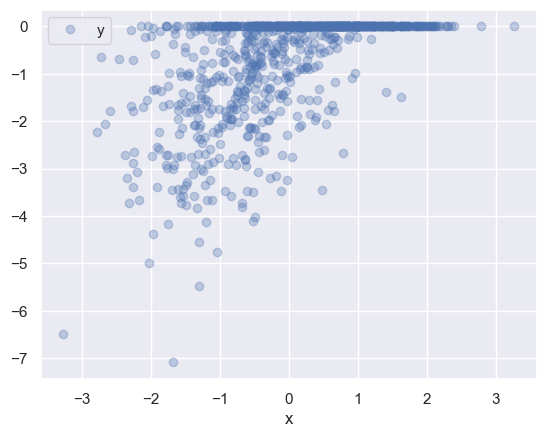

In [2]:
# Load data
data = pd.read_csv('adv micro data.csv')
y = data['y'].values
x = data[['x']].values
print(x.shape, y.shape)

fig,ax = plt.subplots();
ax.plot(x, y, 'o', alpha=0.3, label='y');
ax.set_xlabel('x');
ax.legend();
plt.show()

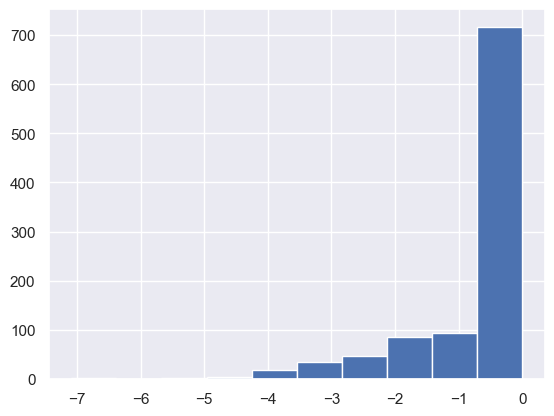

In [3]:
plt.hist(y) ;
#plt.hist(x)

In [273]:
theta0 = tibot.starting_values(y,x)[:2]
mu0 = theta0[-1]
print('Starting values:', theta0, mu0)
print('Log-likelihood at starting values:', tibot.loglikelihood(theta0, y, x))

Starting values: [0.58643433 1.06488424] 0.6688491853608395
Log-likelihood at starting values: [ -2.72239505  -1.03031741  -0.98183156  -1.1710457   -1.59902909
  -2.28155662  -2.2597122   -1.34926713  -1.6122484   -0.79968237
  -0.42295507  -0.92782793  -1.79401787  -0.76060776  -1.07353248
  -1.0521163   -1.52621017  -1.7482013   -1.22192195  -1.43847232
  -0.67574743  -1.53271702  -0.9823305   -1.30587726  -0.89095616
  -1.03067402  -1.08364372  -1.41406376  -1.22383973  -0.83916972
  -0.57753905  -0.85587389  -1.38175593  -1.10826788  -2.08912733
  -0.98520727  -1.11499087  -0.98756566  -0.88310741  -0.809455
  -1.05228759  -1.02943964  -1.5226661   -1.07999916  -1.37661274
  -0.6128189   -2.01215639  -0.72249301  -1.01018645  -1.01443646
  -0.27765584  -0.81698971  -1.02970807  -1.00670134  -0.32702322
  -1.12703975  -0.50688185  -0.80192714  -0.72365437  -1.13959349
  -1.32067048  -0.62165937  -1.04068923  -1.04298845  -1.16049768
  -0.843816    -1.08278032  -1.0686214  -14.32434

In [274]:
res1 = estimation.estimate(tibot.q, theta0, y, x)
result_dict1 = {'Starting values': theta0, 
              'Estimated values': res1['theta'], 
              't': res1['t']}
lab_theta = ['x', 'sigma']

pd.DataFrame(result_dict1, index=lab_theta).round(3)

Optimization terminated successfully.
         Current function value: -18.420681
         Iterations: 1
         Function evaluations: 18
         Gradient evaluations: 6


LinAlgError: Singular matrix

In [ ]:
sigma1_tibot = res1.get('theta')[-1]
sig1_tibot   = res1.get('theta')[-1]
b1_tibot     = res1.get('theta')[:-1]
b1_se_tibot  = res1.get('se')[:-1]

xb1 = x@b1_tibot
y_hat1 = xb1*norm.cdf((xb1)/sigma1_tibot) + sigma1_tibot*norm.pdf((xb1)/sigma1_tibot)
residuals = y_hat1 - xb1
mu = np.mean(residuals)
rho1 = np.corrcoef(y.flatten(), y_hat1.flatten())[0, 1]
R2_tibot = rho1*rho1

tab1 = pd.DataFrame({'b_tibot': b1_tibot, 'se': b1_se_tibot}, index=['x'])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': sig1_tibot, 'se': res1['se'][-1]}, index=['sigma'])])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': mu, 'se': np.std(residuals)}, index=['mu'])])
tab1 = pd.concat([tab1,pd.DataFrame({'b_tibot': '', 'se': R2_tibot}, index=['R2'])])

tab1.round(5)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

## Partial effects 


In [ ]:
thetahat = res1.get('theta')
b_tib = thetahat[:-1]
sigma_tib = thetahat[-1]

x0 = np.mean(x, axis=0)
x0 = x0*x0  # Square of mean, and not mean of square.

def mills_ratio(z):
    return norm.pdf(z) / norm.cdf(z)

def marg_effect(x, b_tib, sigma_tib, mu):
    xb = x@b_tib
    phi = norm.cdf((xb+mu)/sigma_tib)
    
    h = 1e-8
    phi = np.clip(phi, h, 1-h)

    # Implied "censoring" probability, P(Y=0|X=x) = phi
    # Partial effect of censoring, dE(y=0|X=x)/dx
    marg1 = (b_tib/sigma_tib)*phi

    # Implied effect on conditional mean, P(Y|X=x)
    marg2 = (1-norm.pdf((xb + mu)/sigma_tib))*(xb+mu) - sigma_tib*phi
    # Partial effect of conditional mean, dE(y|X=x)/dx
    marg2 = 

    return marg1, 

# Calculate the marginal effect and print out the effect
marg1, marg2 = marg_effect(x0, b_tob, sigma_tob, mu)
table = [
    ['dE(y|x,y<0)/dx', marg1], 
    ['dE(y|x)/dx', marg2]
]
print('Marginal effect')
print(tabulate(table))

TypeError: marg_effect() missing 1 required positional argument: 'mu'